In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [3]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'studentsperformance'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

education_df = pd.read_sql_query('select * from studentsperformance',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

### 1. Are the exam score variables distributed normally? If not, apply Box-Cox transformation. Does anything change?

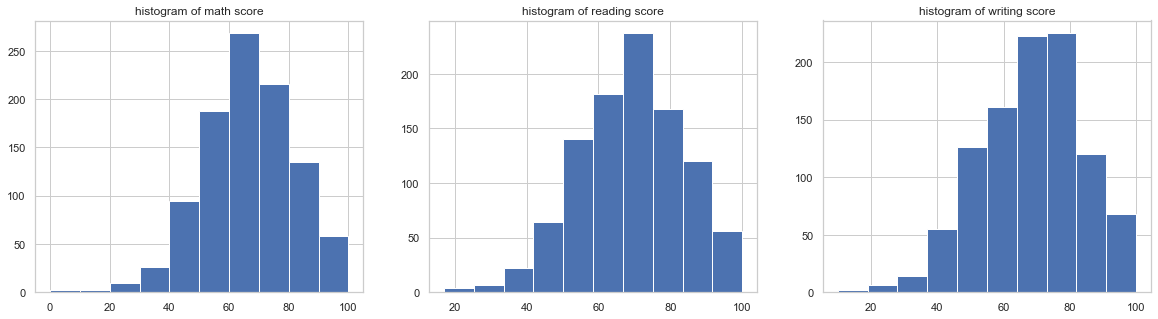

In [19]:
plt.figure(figsize = (20,5))
plt.subplot(1, 3, 1)
plt.hist(education_df["math score"])
plt.title("histogram of math score")

plt.subplot(1, 3, 2)
plt.hist(education_df["reading score"])
plt.title("histogram of reading score")

plt.subplot(1, 3, 3)
plt.hist(education_df["writing score"])
plt.title("histogram of writing score")

plt.show();

From the graphs above, the data look normally distributed, but we will need to test if this is actually the case.

In [7]:
print(stats.jarque_bera(education_df['math score']))
print(stats.jarque_bera(education_df['reading score']))
print(stats.jarque_bera(education_df['writing score']))

(15.912256686712709, 0.0003505075386818213)
(11.383300575987892, 0.0033740202672214448)
(13.98509448257235, 0.0009187033894586527)


From the Jarque-Bera tests, we can see that none of the variables are normally distributed (p values less than .05). We should now apply a Box Cox transformation.

In [9]:
print(education_df['math score'].min())
print(education_df['reading score'].min())
print(education_df['writing score'].min())

0
17
10


Unfortunately, we cannot use all of our data in the `math score` column because one of the values is 0. For a Box Cox transformation, all values must be greater than 0.

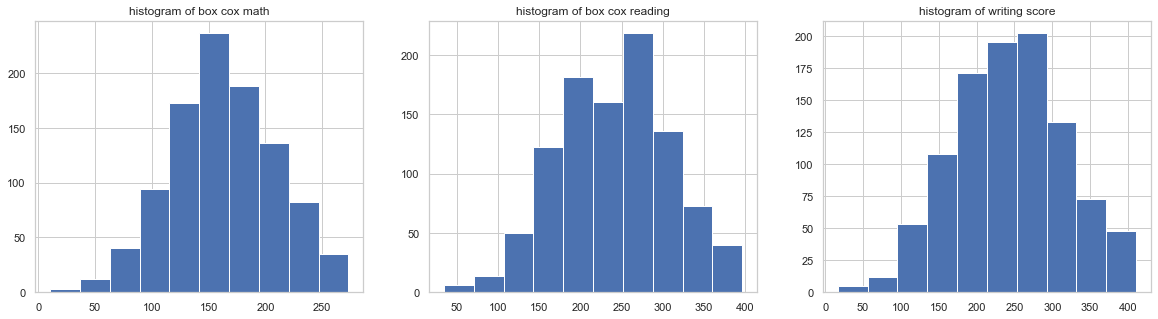

In [21]:
#apply Box Cox transformation to each variable
math_boxcox,_ = stats.boxcox(education_df[education_df["math score"] > 0]["math score"])
reading_boxcox,_ = stats.boxcox(education_df["reading score"])
writing_boxcox,_ = stats.boxcox(education_df["writing score"])

plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
plt.hist(math_boxcox)
plt.title("histogram of box cox math")

plt.subplot(1, 3, 2)
plt.hist(reading_boxcox)
plt.title("histogram of box cox reading")

plt.subplot(1, 3, 3)
plt.hist(writing_boxcox)
plt.title("histogram of writing score")

plt.show();

In [22]:
#test if the transformed variables are normal
print(stats.jarque_bera(math_boxcox))
print(stats.jarque_bera(reading_boxcox))
print(stats.jarque_bera(writing_boxcox))

(1.720098104874378, 0.4231413256953709)
(4.119778575331906, 0.1274680814024559)
(4.746478090040098, 0.09317842784055597)


Now, all of the variables are normally distributed (p greater than .05).

### 2. Say we want to use a single variable for the exam scores as our target. For this purpose, create a new variable by taking a weighted average of the exam scores. Check whether this new variable is normally distributed. If it's not normally distributed, apply a Box-Cox transformation and check whether or not the transformed variable is normally distributed.

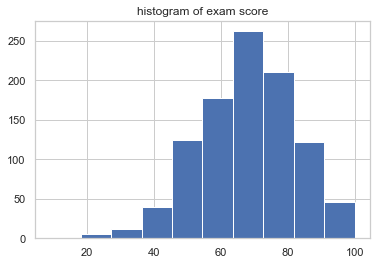

DescribeResult(nobs=1000, minmax=(9.0, 100.0), mean=67.77066666666666, variance=203.271344233122, skewness=-0.29860834478379217, kurtosis=0.1192205335333627)


In [27]:
# create new exam score variable
education_df['exam score'] = (education_df['math score'] + education_df['reading score'] + education_df['writing score'])/3
plt.hist(education_df['exam score'])
plt.title("histogram of exam score")
plt.show();
print(stats.describe(education_df['exam score']))

The `stats.describe` call tells us that this is likely within the acceptable range for a normally distributed variable; however, we should still use a `jarque_bera` test to confirm.

In [29]:
#jarque bera test of new variable
stats.jarque_bera(education_df['exam score'])

(15.453387913085168, 0.00044089934264401887)

The Jarque-Bera test tells us that our variable is not, in fact, normally distributed. Time for a Box Cox transformation!

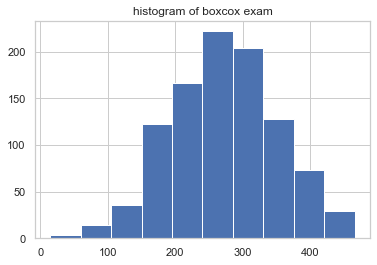

(2.4353987431906026, 0.29591016374203183)


In [33]:
exam_boxcox,_ = stats.boxcox(education_df["exam score"])

plt.hist(exam_boxcox)
plt.title('histogram of boxcox exam')
plt.show();

print(stats.jarque_bera(exam_boxcox))

Our variable is now truly normally distributed.

### 3. Which variables seem related to the target variable (the newly created variable in the previous question)? If our goal is to explain the determinants of success in exams, which variables in our dataset might be useful?

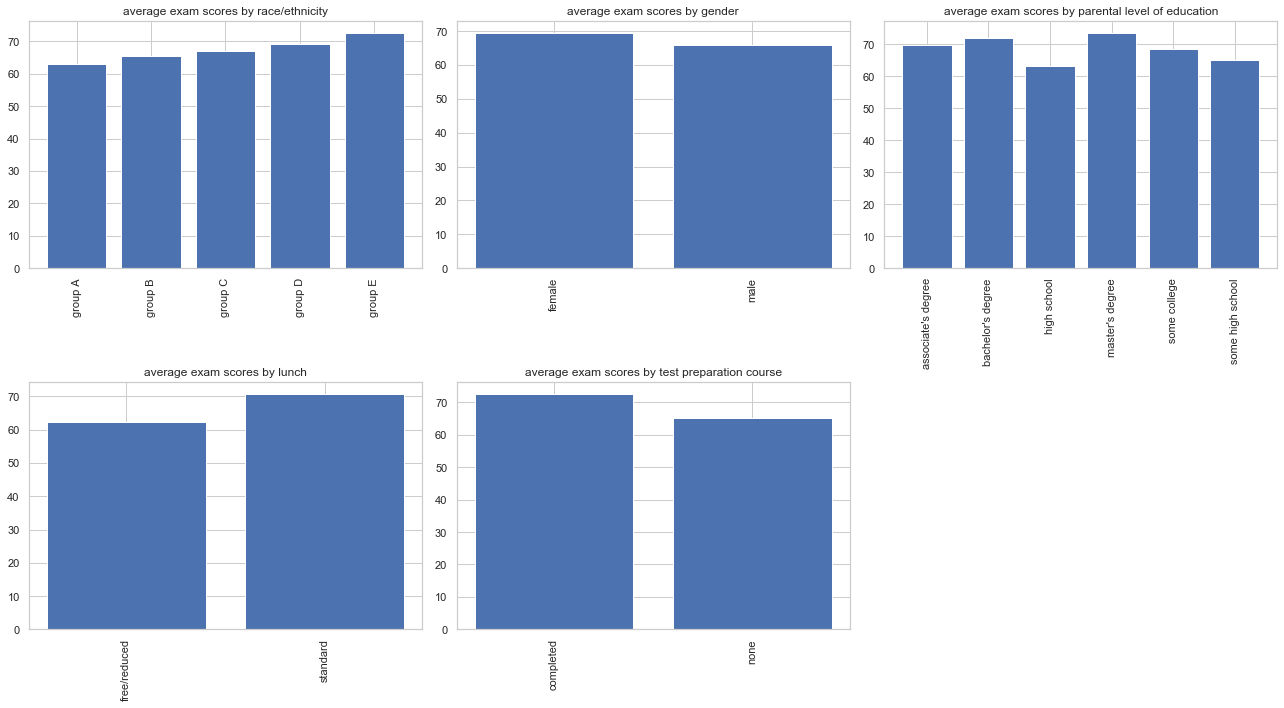

In [36]:
plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.bar(education_df.groupby("race/ethnicity")
        ["exam score"].mean().index, education_df.groupby("race/ethnicity")["exam score"].mean())

plt.title("average exam scores by race/ethnicity")
plt.xticks(rotation="vertical")

plt.subplot(2, 3, 2)
plt.bar(education_df.groupby("gender")
        ["exam score"].mean().index, education_df.groupby("gender")["exam score"].mean())

plt.title("average exam scores by gender")
plt.xticks(rotation="vertical")

plt.subplot(2, 3, 3)
plt.bar(education_df.groupby("parental level of education")
        ["exam score"].mean().index, education_df.groupby("parental level of education")["exam score"].mean())

plt.title("average exam scores by parental level of education")
plt.xticks(rotation="vertical")

plt.subplot(2, 3, 4)
plt.bar(education_df.groupby("lunch")
        ["exam score"].mean().index, education_df.groupby("lunch")["exam score"].mean())

plt.title("average exam scores by lunch")
plt.xticks(rotation="vertical")

plt.subplot(2, 3, 5)
plt.bar(education_df.groupby("test preparation course")
        ["exam score"].mean().index, education_df.groupby("test preparation course")["exam score"].mean())
plt.title("average exam scores by test preparation course")
plt.xticks(rotation="vertical")

plt.tight_layout()
plt.show();

- Across ethnicities, average exam score increases as we go from Group A to Group E. This suggests that race/ethnicity may play a significant factor in determining exam score.

- Females tend to score more highly than males on average.

- Although it may not be significant, there to appear to be differences in average exam scores when parental level of education is taken into account.

- Students getting standard lunch score more highly than those getting free/reduced lunch.

- Students who have completed the test preparation course score more highly on average.